In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load data 

### Transactions data

To reduce memory consupution, load first a small set, determine the columns type, and replace them with low-precision ones


In [2]:
sample = pd.read_csv('../input/new_merchant_transactions.csv.zip',nrows=10)
dtypes = sample.dtypes

col_types = {}
remap = {np.int64: np.int16, np.float64:np.float16}
for column,typ in dtypes.items():
    col_types[column] = remap.get(typ.type,typ.type)

col_types["purchase_amount"] = np.float32
    
col_types


{'authorized_flag': numpy.object_,
 'card_id': numpy.object_,
 'city_id': numpy.int16,
 'category_1': numpy.object_,
 'installments': numpy.int16,
 'category_3': numpy.object_,
 'merchant_category_id': numpy.int16,
 'merchant_id': numpy.object_,
 'month_lag': numpy.int16,
 'purchase_amount': numpy.float32,
 'purchase_date': numpy.object_,
 'category_2': numpy.float16,
 'state_id': numpy.int16,
 'subsector_id': numpy.int16}

#### Actually load transactions here. 



In [3]:
new_transactions = pd.read_csv('../input/new_merchant_transactions.csv.zip', parse_dates=['purchase_date'],dtype=col_types)
historical_transactions = pd.read_csv('../input/historical_transactions.csv.zip', parse_dates=['purchase_date'],dtype=col_types)

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0}).astype(np.int8)
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

#### Merge historical and new transactions

In [4]:
historical_transactions["historical"] = 1
new_transactions["historical"] = 0

all_transactions = pd.concat([historical_transactions,new_transactions])

In [5]:
all_transactions["merchant_id"] = all_transactions["merchant_id"].fillna("") 

### Merchant data and basics features

In [6]:
merchants = pd.read_csv("../input/merchants.csv.zip")

In [7]:
train = pd.read_csv("../input/train.csv.zip",parse_dates=['first_active_month'])

In [8]:
test = pd.read_csv("../input/test.csv.zip",parse_dates=['first_active_month'])

In [9]:
merchants.columns

Index(['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'numerical_1', 'numerical_2', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'city_id', 'state_id', 'category_2'],
      dtype='object')

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
merchants.describe().T

,count,mean,std,min,25%,50%,75%,max
merchant_group_id,334696.0,3.102874e+04,31623.043426,1.000000,3612.000000,19900.000000,51707.250000,1.125860e+05
merchant_category_id,334696.0,4.231317e+02,252.898046,-1.000000,222.000000,373.000000,683.000000,8.910000e+02
subsector_id,334696.0,2.511640e+01,9.807371,-1.000000,19.000000,27.000000,33.000000,4.100000e+01
numerical_1,334696.0,1.147638e-02,1.098154,-0.057471,-0.057471,-0.057471,-0.047556,1.837351e+02
numerical_2,334696.0,8.103110e-03,1.070497,-0.057471,-0.057471,-0.057471,-0.047556,1.820793e+02
avg_sales_lag3,334683.0,1.383299e+01,2395.489999,-82.130000,0.880000,1.000000,1.160000,8.518446e+05
avg_purchases_lag3,334696.0,inf,NaN,0.333495,0.923650,1.016667,1.146522,inf
active_months_lag3,334696.0,2.994108e+00,0.095247,1.000000,3.000000,3.000000,3.000000,3.000000e+00
avg_sales_lag6,334683.0,2.165079e+01,3947.108099,-82.130000,0.850000,1.010000,1.230000,1.513959e+06
avg_purchases_lag6,334696.0,inf,NaN,0.167045,0.902247,1.026961,1.215575,inf


In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_1,201917.0,3.105311,1.186160,1.000000,2.00000,3.000000,4.000000,5.000000
feature_2,201917.0,1.745410,0.751362,1.000000,1.00000,2.000000,2.000000,3.000000
feature_3,201917.0,0.565569,0.495683,0.000000,0.00000,1.000000,1.000000,1.000000
target,201917.0,-0.393636,3.850500,-33.219281,-0.88311,-0.023437,0.765453,17.965068


In [13]:
all_transactions.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id', 'historical'],
      dtype='object')

In [14]:
all_transactions.describe().T

,count,mean,std,min,25%,50%,75%,max
authorized_flag,31075392.0,0.919006,0.272825,0.000000,1.000000,1.000000,1.000000,1.0
city_id,31075392.0,129.645324,104.092565,-1.000000,53.000000,90.000000,212.000000,347.0
category_1,31075392.0,0.069094,0.253614,0.000000,0.000000,0.000000,0.000000,1.0
installments,31075392.0,0.650673,2.734985,-1.000000,0.000000,0.000000,1.000000,999.0
merchant_category_id,31075392.0,477.851821,249.482143,-1.000000,302.000000,454.000000,705.000000,891.0
month_lag,31075392.0,-4.110560,3.766495,-13.000000,-7.000000,-3.000000,-1.000000,2.0
purchase_amount,31075392.0,0.022308,1087.456055,-0.746908,-0.719905,-0.687523,-0.600865,6010604.0
category_2,28310783.0,NaN,0.000000,1.000000,1.000000,1.000000,3.000000,5.0
state_id,31075392.0,10.586618,6.347145,-1.000000,9.000000,9.000000,16.000000,24.0
subsector_id,31075392.0,26.793295,9.723248,-1.000000,19.000000,29.000000,34.000000,41.0


* `purchase_amount` is sometimes inf

In [15]:
inf_purch = all_transactions.purchase_amount == np.inf

inf_purch.sum()

0

In [16]:
all_transactions.purchase_amount[inf_purch] = all_transactions.purchase_amount[~inf_purch].max()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
all_transactions["purchase_amount"] = all_transactions["purchase_amount"].astype(np.float32)

In [18]:
all_transactions.describe().T

,count,mean,std,min,25%,50%,75%,max
authorized_flag,31075392.0,0.919006,0.272825,0.000000,1.000000,1.000000,1.000000,1.0
city_id,31075392.0,129.645324,104.092565,-1.000000,53.000000,90.000000,212.000000,347.0
category_1,31075392.0,0.069094,0.253614,0.000000,0.000000,0.000000,0.000000,1.0
installments,31075392.0,0.650673,2.734985,-1.000000,0.000000,0.000000,1.000000,999.0
merchant_category_id,31075392.0,477.851821,249.482143,-1.000000,302.000000,454.000000,705.000000,891.0
month_lag,31075392.0,-4.110560,3.766495,-13.000000,-7.000000,-3.000000,-1.000000,2.0
purchase_amount,31075392.0,0.022308,1087.456055,-0.746908,-0.719905,-0.687523,-0.600865,6010604.0
category_2,28310783.0,NaN,0.000000,1.000000,1.000000,1.000000,3.000000,5.0
state_id,31075392.0,10.586618,6.347145,-1.000000,9.000000,9.000000,16.000000,24.0
subsector_id,31075392.0,26.793295,9.723248,-1.000000,19.000000,29.000000,34.000000,41.0


In [19]:
# ( all_transactions.isna() | all_transactions == np.inf).sum(axis=0)

### Categorical features

In [20]:
merchants_categorical_features = ["merchant_id","city_id","merchant_category_id","state_id"]

transactions_categorical_features = ["category_1","category_2","category_3","installments"]

In [21]:
uniques = {}
for col in transactions_categorical_features+merchants_categorical_features:
    uniques[col] = all_transactions[col].unique()

In [22]:
uniques

{'category_1': array([0, 1]),
 'category_2': array([ 1., nan,  3.,  5.,  2.,  4.]),
 'category_3': array(['A', 'B', 'C', nan], dtype=object),
 'installments': array([  0,   1,   5,   3,   4,   2,  -1,  10,   6,  12,   8,   7,   9,
         11, 999]),
 'merchant_id': array(['M_ID_e020e9b302', 'M_ID_86ec983688', 'M_ID_979ed661fc', ...,
        'M_ID_d722baf580', 'M_ID_79edabf769', 'M_ID_4247d8f9d5'],
       dtype=object),
 'city_id': array([ 88, 333,   3,  -1,  69, 233, 322, 138, 226, 330, 278, 221,  19,
        331, 211, 209, 193,  11, 161, 105, 329,  42, 251, 338, 344,  87,
         63, 229, 170, 135, 107,  20,  57,  17, 212, 277, 280, 117,  85,
        301,  25,  86,  96,  38, 283, 116, 188, 250, 231, 158, 272, 311,
         49, 296, 148,  90, 275, 108,  30, 302, 143,  66, 291, 137, 147,
          4, 163,  24, 109, 314, 131,   2, 144, 340,  62, 160, 157, 216,
         53, 149,  47, 169,  14, 342,  26, 120,  56, 162, 213, 259, 247,
        264, 288,  12, 223, 304, 230, 155, 106, 279, 1

* `category_2` encoded as a float
* missing values for `city_id`, `merchand_category_id`,  `state_id` and `installments` seem to be -1 

In [23]:
all_transactions["category_2"] = all_transactions["category_2"].fillna(-1).astype(np.int8)

category_3_map = {'A':0, 'B':1, 'C':2, np.nan:-1}
all_transactions["category_3"] = all_transactions["category_3"].apply(category_3_map.get)

In [24]:
for col in merchants_categorical_features:
    print(col, "only in merchants", set(uniques[col]) - set(merchants[col].unique()), "only in transactions", set(merchants[col].unique()) - set(uniques[col]))

merchant_id only in merchants {''} only in transactions set()
city_id only in merchants {264, 138, 266, 273, 19, 20, 149, 280, 292, 170, 298, 302, 179, 54, 185, 57, 315, 316, 319, 322, 195, 197, 199, 75, 331, 79, 207, 335, 344, 222, 227, 102, 103, 107, 109, 244, 122} only in transactions set()
merchant_category_id only in merchants {192, 37, 27, 687, 817, 882, 311, 603, 220} only in transactions {776, 566}
state_id only in merchants set() only in transactions set()


* two `merchant_ids`, 776 and 566 are only in transactions 

In [25]:
non_cat_features = [ cat for cat in all_transactions if not cat in transactions_categorical_features+merchants_categorical_features   ]

In [26]:
merchant_encoder = LabelEncoder()
merchant_encoder.fit(uniques["merchant_id"])

merchants["merchant_id"] = merchant_encoder.transform(merchants["merchant_id"])
all_transactions["merchant_id"] = merchant_encoder.transform(all_transactions["merchant_id"])

In [27]:
import pickle

with open("merchant_encoder.pkl","wb+") as fout:
    fout.write( pickle.dumps(merchant_encoder) )

In [28]:
missing = ( all_transactions[transactions_categorical_features+merchants_categorical_features] == -1 )
non_cat_missing = all_transactions[non_cat_features].isna()

missing = missing.join(non_cat_missing)

In [29]:
coocc = missing.T.astype(np.int).dot(missing.astype(np.int))

In [30]:
import matplotlib.pyplot as plt

In [31]:
coocc /= all_transactions.shape[0]

In [32]:
coocc

,category_1,category_2,category_3,installments,merchant_id,city_id,merchant_category_id,state_id,authorized_flag,card_id,month_lag,purchase_amount,purchase_date,subsector_id,historical
category_1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
category_2,0.0,0.097438,0.000554,0.000554,0.0,0.090700,0.000075,0.097438,0.0,0.0,0.0,0.0,0.0,0.0,0.0
category_3,0.0,0.000554,0.009536,0.009536,0.0,0.000481,0.000000,0.000554,0.0,0.0,0.0,0.0,0.0,0.0,0.0
installments,0.0,0.000554,0.009536,0.009536,0.0,0.000481,0.000000,0.000554,0.0,0.0,0.0,0.0,0.0,0.0,0.0
merchant_id,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
city_id,0.0,0.090700,0.000481,0.000481,0.0,0.090700,0.000075,0.090700,0.0,0.0,0.0,0.0,0.0,0.0,0.0
merchant_category_id,0.0,0.000075,0.000000,0.000000,0.0,0.000075,0.000076,0.000075,0.0,0.0,0.0,0.0,0.0,0.0,0.0
state_id,0.0,0.097438,0.000554,0.000554,0.0,0.090700,0.000075,0.097438,0.0,0.0,0.0,0.0,0.0,0.0,0.0
authorized_flag,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
card_id,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* a missing `category_2` almost always co-occur with a missing `state_id` or `city_id` roughly 10% of the total transactions

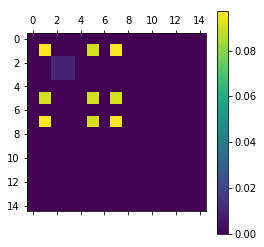

In [33]:
plt.matshow(coocc)
plt.colorbar()

In [34]:
# historical_missing = ( all_transactions[ all_transactions.historical == 1][transactions_categorical_features+merchants_categorical_features] == -1 )

In [35]:
# historical_coocc = historical_missing.T.astype(np.int).dot(historical_missing.astype(np.int))

In [36]:
# historical_coocc / all_transactions.shape[0]

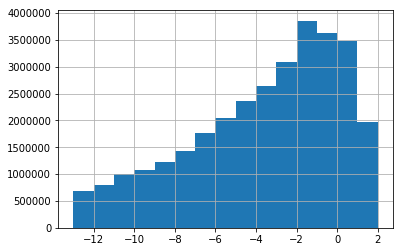

In [37]:
all_transactions.month_lag.hist(bins=15)

In [38]:
# all_transactions.plot.scatter(x="historical",y="month_lag")

In [39]:
# # sample_card_ids = train.card_id.sample(1000) .tolist()

# # sample_transactions = all_transactions.card_id.apply( lambda x: x in sample_card_ids )

# # grouped= all_transactions[sample_transactions].groupby("card_id")

# # # all_transactions[ all_transactions["card_id"] == "C_ID_4e6213e9bc" ].month_lag.hist()

# # # grouped["month_lag"].hist(bins=15,range=[-12.5,2.5],alpha=0.5)
# # grouped["month_lag"].hist(bins=15,range=[-12.5,2.5],histtype="step",label=None)
# # # plt.legend()

# # # grouped.groups
# # # "C_ID_6242b8f73e" in sample_card_ids.tolist()

# sample_train = train[ train.card_id.apply(lambda x: x in sample_card_ids) ]

# sample_aggr = grouped["month_lag"].aggregate(["mean","std"])

# sample_train = sample_train.set_index("card_id").join(sample_aggr)

# sample_train.plot.scatter(x="std",y="target")

# sample_train.plot.scatter(x="mean",y="target")

# # historical_transactions_by_mechant= historical_transactions.groupby('merchant_id')

In [40]:
def merch_entity(x):
    ret = str(x[0])
    for ix in x[1:]:
        ret += "_"+str(ix)
    return ret

# historical_transactions["merch_entity"] = historical_transactions[["merchant_id","state_id","subsector_id","state_id","city_id"]].apply(merch_entity)

In [41]:
cards = pd.concat( [train.card_id,test.card_id] )

card_encoder = LabelEncoder()

card_encoder.fit(cards)
with open("card_encoder.pkl","wb+") as fout:
    fout.write( pickle.dumps(card_encoder) )

In [42]:
train["card_id"] = card_encoder.transform(train["card_id"])
test["card_id"] = card_encoder.transform(test["card_id"])
all_transactions["card_id"] = card_encoder.transform(all_transactions["card_id"])

In [43]:
all_transactions.to_hdf("../input/all_transactions.hd5","all_transactions",mode="w")
merchants.to_hdf("../input/merchants.hd5","merchants",mode="w")

train.to_hdf("../input/train.hd5","train",mode="w")
test.to_hdf("../input/test.hd5","test",mode="w")



In [44]:
merchants.dtypes

merchant_id                      int64
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
numerical_1                    float64
numerical_2                    float64
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
avg_sales_lag3                 float64
avg_purchases_lag3             float64
active_months_lag3               int64
avg_sales_lag6                 float64
avg_purchases_lag6             float64
active_months_lag6               int64
avg_sales_lag12                float64
avg_purchases_lag12            float64
active_months_lag12              int64
category_4                      object
city_id                          int64
state_id                         int64
category_2                     float64
dtype: object

In [45]:
# train.feature_3.unique()

In [ ]:
grouped = all_transactions.groupby("card_id")

merchant_corpus = grouped["merchant_id"].aggregate(lambda x: " ".join(x.astype(str).tolist()) )

state_corpus = grouped["state_id"].aggregate(lambda x: " ".join(x.astype(str).tolist()) )

city_corpus = grouped["city_id"].aggregate(lambda x: " ".join(x.astype(str).tolist()) )

subsector_corpus = grouped["subsector_id"].aggregate(lambda x: " ".join(x.astype(str).tolist()) )

In [ ]:
save_as = dict(merchant_corpus=merchant_corpus,state_corpus=state_corpus,city_corpus=city_corpus,subsector_corpus=subsector_corpus)

for fname,obj in save_as.items():
    with open(fname+".txt","wt+") as fout:
        for row,val in obj.items():
            fout.write(val+"\n")
    fout.close()


In [ ]:
! sudo halt

In [ ]:
# aggregate = {
#     "card_id" : ["nunique"]
    
# }

# historical_transactions_by_mechant.aggregate(aggregate)

In [ ]:
# merchants["avg_purchases_lag3"]

In [ ]:
# historical_transactions_by_card = historical_transactions.groupby("card_id")

In [ ]:
# aggregated_transactios_by_card = historical_transactions_by_card.aggregate( {"city_id" : ["count","nunique"]})

In [ ]:
# aggregated_transactios_by_card["city_id","nunique"].hist(range=[0,50],bins=50)

In [ ]:
# new_transactions_by_card = new_transactions.groupby("card_id")
# aggregated_new_transactios_by_card = new_transactions_by_card.aggregate( {"city_id" : ["count","nunique"]})

In [ ]:
# aggregated_new_transactios_by_card["city_id","nunique"].hist(range=[0,50],bins=50)

In [ ]:
# joined_aggregated_transaction = aggregated_transactios_by_card.join(aggregated_new_transactios_by_card,lsuffix="_hist",rsuffix="_new")

In [ ]:
# plt.hist2d(joined_aggregated_transaction["city_id_hist","nunique"],joined_aggregated_transaction["city_id_new","nunique"],range=[ [0,50],[0,10] ],bins=[50,10]);

In [ ]:
# train = train.set_index("card_id").join(joined_aggregated_transaction)

In [ ]:
# train[[("city_id_hist","nunique"),("city_id_new","nunique"),'target']].corr()

In [ ]:
# np.log(np.abs(train.target)).hist(bins=200)